In [80]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy
from umap import UMAP




In [38]:
bert_embeddings = np.load("bert_embeddings_up.npz")
bert_embeddings = bert_embeddings['arr_0']
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(bert_embeddings)
input_dim = bert_embeddings.shape[1]  

In [ ]:
class CustomAutoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(CustomAutoencoder, self).__init__()
        # Encoder
        self.input_noise = layers.GaussianNoise(0.05)  
        self.encoder_dense1 = layers.Dense(
            latent_dim, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.encoder_dense2 = layers.Dense(
            256, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.encoder_latent = layers.Dense(
            latent_dim, activation='relu',
            kernel_regularizer=regularizers.l1(1e-5)  
        )
        self.latent_noise = layers.GaussianNoise(0.05)
        self.latent_normalization = layers.LayerNormalization()

        # Decoder
        self.decoder_dense1 = layers.Dense(
            256, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.decoder_dense2 = layers.Dense(
            512, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')

    def call(self, inputs):
        # Encoder
        x = self.input_noise(inputs)  
        x = self.encoder_dense1(x)
        skip = x  
        x = self.encoder_dense2(x)
        latent = self.encoder_latent(x)
        latent = self.latent_noise(latent)  
        latent = self.latent_normalization(latent)  
        latent = layers.add([latent, skip])  

        # Decoder
        x = self.decoder_dense1(latent)
        x = self.decoder_dense2(x)
        reconstruction = self.decoder_output(x)
        return reconstruction, latent



input_dim = normalized_embeddings.shape[1]
latent_dim = 512  
custom_autoencoder = CustomAutoencoder(input_dim=input_dim, latent_dim=latent_dim)


In [40]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [41]:
def clustering_loss(latent_embeddings, lambda_cluster=1.0):
    mean_embedding = tf.reduce_mean(latent_embeddings, axis=0)
    distances = tf.norm(latent_embeddings - mean_embedding, axis=1)
    cluster_penalty = tf.reduce_mean(distances)
    return lambda_cluster * cluster_penalty

def combined_loss(y_true, y_pred, latent_embeddings, lambda_recon=1.0, lambda_cluster=0.5):
    recon_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    cluster_loss = clustering_loss(latent_embeddings, lambda_cluster)

    return lambda_recon * recon_loss + lambda_cluster * cluster_loss


In [42]:
@tf.function
def pretrain_step(x_batch):
    with tf.GradientTape() as tape:
        y_pred, _ = custom_autoencoder(x_batch)
        loss = tf.reduce_mean(tf.square(x_batch - y_pred))
    gradients = tape.gradient(loss, custom_autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(gradients, custom_autoencoder.trainable_weights))
    return loss


In [43]:
@tf.function
def train_step(x_batch):
    with tf.GradientTape() as tape:
        y_pred, latent = custom_autoencoder(x_batch)
        loss = combined_loss(x_batch, y_pred, latent)
    gradients = tape.gradient(loss, custom_autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(gradients, custom_autoencoder.trainable_weights))
    return loss


In [ ]:
history = {'loss': [], 'silhouette': [], 'davies_bouldin': []}

pretrain_epochs = 5
fine_tune_epochs = 20
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_embeddings).batch(batch_size)

print("Starting Pretraining...")
for epoch in range(pretrain_epochs):
    print(f"Pretraining Epoch {epoch + 1}/{pretrain_epochs}")
    epoch_loss = 0

    for step, x_batch in enumerate(train_dataset):
        loss = pretrain_step(x_batch)  
        epoch_loss += loss.numpy()

    avg_loss = epoch_loss / (step + 1)
    print(f"Reconstruction Loss: {avg_loss:.4f}")

print("\nStarting Fine-tuning...")
for epoch in range(fine_tune_epochs):
    print(f"Fine-tuning Epoch {epoch + 1}/{fine_tune_epochs}")
    epoch_loss = 0

    for step, x_batch in enumerate(train_dataset):
        loss = train_step(x_batch)
        epoch_loss += loss.numpy()

    latent_embeddings = custom_autoencoder(normalized_embeddings)[1].numpy()

    kmeans = KMeans(n_clusters=5, random_state=42).fit(latent_embeddings)

    unique_labels = len(set(kmeans.labels_))
    if unique_labels > 1:  
        silhouette = silhouette_score(latent_embeddings, kmeans.labels_)
        davies_bouldin = davies_bouldin_score(latent_embeddings, kmeans.labels_)
    else:
        silhouette = -1  
        davies_bouldin = float('inf')  

    avg_loss = epoch_loss / (step + 1)
    history['loss'].append(avg_loss)
    history['silhouette'].append(silhouette)
    history['davies_bouldin'].append(davies_bouldin)

    print(f"Loss: {avg_loss:.4f}, Silhouette: {silhouette:.4f}, DB Index: {davies_bouldin:.4f}")


Starting Pretraining...
Pretraining Epoch 1/5
Reconstruction Loss: 0.8497
Pretraining Epoch 2/5
Reconstruction Loss: 0.7200
Pretraining Epoch 3/5
Reconstruction Loss: 0.6929
Pretraining Epoch 4/5
Reconstruction Loss: 0.6806
Pretraining Epoch 5/5
Reconstruction Loss: 0.6743

Starting Fine-tuning...
Fine-tuning Epoch 1/20
Loss: 2.3439, Silhouette: 0.1285, DB Index: 5.4172
Fine-tuning Epoch 2/20
Loss: 1.1585, Silhouette: 0.2031, DB Index: 2.1221
Fine-tuning Epoch 3/20
Loss: 1.0894, Silhouette: 0.1977, DB Index: 1.9031
Fine-tuning Epoch 4/20
Loss: 1.0641, Silhouette: 0.1437, DB Index: 2.4094
Fine-tuning Epoch 5/20
Loss: 1.0504, Silhouette: 0.5375, DB Index: 1.0100
Fine-tuning Epoch 6/20
Loss: 1.0398, Silhouette: 0.5618, DB Index: 0.9802
Fine-tuning Epoch 7/20
Loss: 1.0317, Silhouette: 0.6496, DB Index: 0.8579
Fine-tuning Epoch 8/20
Loss: 1.0245, Silhouette: 0.7317, DB Index: 1.1239
Fine-tuning Epoch 9/20
Loss: 1.0183, Silhouette: 0.7860, DB Index: 0.6152
Fine-tuning Epoch 10/20
Loss: 1.015

In [45]:
reconstructions, latent_embeddings = custom_autoencoder(normalized_embeddings)
reconstructions = reconstructions.numpy()
latent_embeddings = latent_embeddings.numpy()

assert bert_embeddings.shape == reconstructions.shape, "Shape mismatch between embeddings and reconstructions!"
mse = tf.reduce_mean(tf.square(bert_embeddings - reconstructions)).numpy()
print(f"Reconstruction MSE: {mse:.4f}")


gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(latent_embeddings)

silhouette = silhouette_score(latent_embeddings, gmm_labels)
davies_bouldin = davies_bouldin_score(latent_embeddings, gmm_labels)
print(f"Silhouette Score (GMM): {silhouette:.4f}")
print(f"Davies-Bouldin Index (GMM): {davies_bouldin:.4f}")


Reconstruction MSE: 0.2920
Silhouette Score (GMM): 0.9610
Davies-Bouldin Index (GMM): 2.0877


In [46]:
latent_var = np.var(latent_embeddings, axis=0)
print(f"Latent Embeddings Variance: {latent_var}")

if np.min(latent_var) < 1e-6:
    print("Warning: Some dimensions in latent embeddings have very low variance.")
else:
    print("Latent embeddings have sufficient variance.")
cosine_sim_matrix = cosine_similarity(latent_embeddings)

np.fill_diagonal(cosine_sim_matrix, np.nan)  
avg_cosine_similarity = np.nanmean(cosine_sim_matrix)

print(f"Average Pairwise Cosine Similarity: {avg_cosine_similarity:.4f}")

Latent Embeddings Variance: [9.95805993e-10 1.18507371e-09 4.30674163e-09 1.30748412e-09
 3.05371692e-08 1.12743481e-09 8.03325833e-08 1.99305301e-08
 7.84916665e-09 1.20267019e-09 1.34870639e-08 1.10354670e-09
 6.50794363e-10 1.01890469e-08 1.00418973e-09 1.03276037e-08
 1.55495106e-09 1.30043987e-09 3.02106362e-09 1.14400178e-09
 1.49288244e-08 2.41495757e-09 2.42441474e-05 1.38448684e-08
 1.35403344e-09 1.39322220e-09 1.11901721e-09 3.30334800e-08
 1.02512687e-09 3.69406443e-08 1.65447001e-09 1.00226916e-09
 1.18874810e-09 1.68125880e-09 4.49027704e-09 1.39465495e-09
 1.35715872e-09 1.42425822e-08 1.26803390e-09 1.33514355e-09
 9.34654238e-08 1.14058907e-09 3.53383243e-08 1.52035329e-09
 8.55718909e-08 1.36805554e-08 2.35065549e-08 1.60082037e-09
 1.05008169e-09 1.35507228e-09 5.38031664e-09 1.07304454e-09
 2.00175498e-09 1.01341435e-09 1.19304278e-09 1.40092578e-08
 9.18636223e-10 1.43846268e-09 1.27585542e-09 7.77176812e-09
 2.03467820e-08 1.33419391e-08 1.18586307e-09 1.37704781e

In [47]:
kmeans_labels = KMeans(n_clusters=5, random_state=42).fit_predict(latent_embeddings)

cluster_sizes = np.bincount(kmeans_labels)
cluster_entropy = entropy(cluster_sizes)

print(f"Cluster Entropy: {cluster_entropy:.4f}")


Cluster Entropy: 0.0323


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


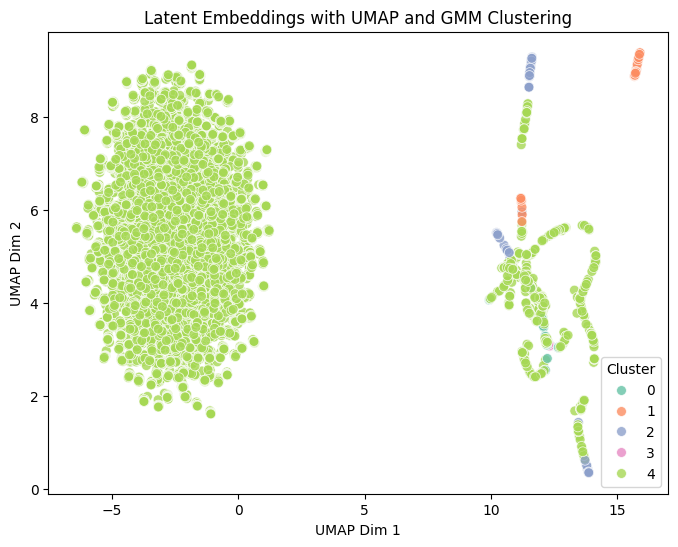

In [48]:
latent_umap = UMAP(n_components=2, random_state=42).fit_transform(latent_embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_umap[:, 0], y=latent_umap[:, 1], hue=gmm_labels, palette="Set2", s=50, alpha=0.8)
plt.title("Latent Embeddings with UMAP and GMM Clustering")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Cluster")
plt.show()


In [77]:
def display_liked_recipes(liked_recipes):
    """
    Display the liked recipes in a table.
    """
    print("Liked Recipes:")
    display(liked_recipes.reset_index(drop=True))  


liked_recipe_indices = [76, 1669, 698]
liked_recipes = recipes_df.iloc[liked_recipe_indices][['title', 'categories', 'ingredients']]

display_liked_recipes(liked_recipes)


Liked Recipes:


,title,categories,ingredients
0,Cheddar Chicken Tenders with Wilted Spinach,"['Food Processor', 'Chicken', 'Leafy Green', '...","['2 tablespoons olive oil', '1 1/2 cups Cheez-..."
1,"Chicken Roasted with Tomatoes, Potatoes, and O...","['Chicken', 'Garlic', 'Olive', 'Potato', 'Toma...","['7 garlic gloves', '1/4 teaspoon salt', '2 te..."
2,Curried Lamb Burgers with Grilled Vegetables a...,"['Sandwich', 'Yogurt', 'High Fiber', 'Backyard...",['1 cup plain whole-milk yogurt (preferably Gr...


In [78]:
def recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5):
  
    if not isinstance(latent_embeddings, np.ndarray):
        latent_embeddings = latent_embeddings.numpy()

    liked_recipe_indices = [idx for idx in liked_recipe_indices if 0 <= idx < len(latent_embeddings)]
    if not liked_recipe_indices:
        raise ValueError("All indices in liked_recipe_indices are out of bounds.")

    print(f"Valid liked_recipe_indices: {liked_recipe_indices}")

    liked_embeddings = latent_embeddings[liked_recipe_indices]
    print(f"Liked Embeddings Shape: {liked_embeddings.shape}")

    similarity_scores = cosine_similarity(liked_embeddings, latent_embeddings)

    aggregated_scores = np.mean(similarity_scores, axis=0)

    recommended_indices = np.argsort(-aggregated_scores)
    recommended_indices = [idx for idx in recommended_indices if idx not in liked_recipe_indices][:top_n]

    return recommended_indices

In [79]:
recommended_recipes = recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5)

recommended_recipes_df = recipes_df.iloc[recommended_recipes][['title', 'categories', 'ingredients']]

display_liked_recipes(recommended_recipes_df)

Valid liked_recipe_indices: [76, 1669, 698]
Liked Embeddings Shape: (3, 512)
Liked Recipes:


,title,categories,ingredients
0,Grilled Lamb Skewers with White-Bean Salad,"['Bean', 'Garlic', 'Lamb', 'Olive', 'Pine Nut'...","['4 large garlic cloves', '2 teaspoons salt', ..."
1,Grilled Lemon Pepper Chicken Breasts with Thym...,"['Chicken', 'Marinate', 'Quick & Easy', 'Low C...","['1/4 cup fresh lemon juice', '1 tablespoon co..."
2,"Burgers with Artichokes, Gorgonzola, and Tomat...","['Pork', 'Tomato', 'Broil', 'Blue Cheese', 'Gr...","['1 6-ounce jar marinated artichoke hearts, dr..."
3,Cornmeal Crepes with Ricotta and Ham,"['Milk/Cream', 'Egg', 'Breakfast', 'Brunch', '...","['1 1/4 cups all-purpose flour', '3/4 cup yell..."
4,Grilled Chicken Salad with Greens and Balsamic...,"['Chicken', 'Leafy Green', 'Olive', 'Poultry',...","['1/2 cup plus 2 tablespoons olive oil', '1/2 ..."
